In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.optim as optim
import math

from sklearn.preprocessing import normalize

In [3]:
from Data_interpret.GroundTruth import ReadMat
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from Robofly_simulator.robot import Robot
import sys
from Raw_data import information_scores


In [4]:


# Loading DATA
project_folder = Path("E:/Dropbox/Daksh/System_ID_project/system_identificatification_robofly/")  # windows path
data_folder = Path("Raw_data/8_8_2019 to 8_12_2019/")
train_file = project_folder / data_folder / "2019-08-08-19-16-02_5sec.mat"
train_file2 = project_folder / data_folder / "2019-08-09-13-01-42_10sec.mat"
train_data = ReadMat(train_file)
train_data2 = ReadMat(train_file2)
# train_data = ReadMat(train_file2)

test_file = project_folder / data_folder / "2019-08-09-12-49-56_7sec.mat"
test_data = ReadMat(test_file)

# SAMPLING DATA
sample_size = 100  # sampling of raw data
train_state_traj, train_action_traj = train_data.sampled_mocap_data(sample_size)  # state X time, number of actions X time
train_state_traj2, train_action_traj2 = train_data2.sampled_mocap_data(sample_size)  # state X time, number of actions X time
test_state_traj, test_action_traj = test_data.sampled_mocap_data(sample_size)

In [5]:
print("train_shape",train_state_traj.shape,"train_action_shape", train_action_traj.shape)
print("train2_shape",train_state_traj2.shape,"train2_action_shape", train_action_traj2.shape)
print("test_shape",test_state_traj.shape,"test_action_traj", test_action_traj.shape)
train_sa1 = np.concatenate((train_state_traj,train_action_traj),axis=0)# train state action trajecctory
train_sa2 = np.concatenate((train_state_traj2,train_action_traj2),axis=0)## train state action trajecctory2
test_sa = np.concatenate((test_state_traj,test_action_traj),axis=0)# test state action trajecctory


train_shape (9, 553) train_action_shape (3, 553)
train2_shape (9, 1056) train2_action_shape (3, 1056)
test_shape (9, 756) test_action_traj (3, 756)


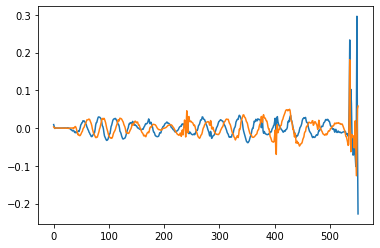

In [6]:
compare= train_state_traj[:,1:]- train_state_traj[:,:-1]
plt.plot(compare.T[:,0:2])

In [55]:
class RoboFlyDataset(torch.utils.data.Dataset):
    def __init__(self, Data_chunk, batch_size,transform=None):
        super(RoboFlyDataset, self).__init__()
        #Data_chunk= 12X # of smaples
        
        
        self.transform= transform
        
        self.dataset,self.labels= self.generate_data_labels(Data_chunk)
        # TODO: Any preprocessing on the data to get it to the right shape.
        #self.time_steps_in_a_batch= self.batch_size*self.sequence_length
        #self.no_of_batches= math.floor(self.n/(self.time_steps_in_a_batch))
        
              
    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of time steps.
        no_of_sequences = self.dataset.shape[1]
        return no_of_sequences
    def generate_data_labels(self,Data_chunk):

        dataset= Data_chunk[:,:-1]
        labels= Data_chunk[:9,1:]
        if (self.transform):
            dataset= normalize(dataset)
        return dataset,labels
        
    def __getitem__(self, idx):
        # Return the data and label for a time sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        location= idx
        numpy_data= self.dataset[:,location]
        data= torch.FloatTensor(numpy_data)
        label= torch.FloatTensor(self.labels[:,location])
        return (data,label)

In [56]:
TEMPERATURE = 0.5

class LSTMRoboflyNet(nn.Module):
    def __init__(self, input_size, output_size, LSTM_output):
        super(LSTMRoboflyNet, self).__init__()
        self.output_size = output_size
        self.input_size = input_size
        
        self.fc1 = nn.Linear(self.input_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,self.output_size)
        #self.fc2 = nn.Linear(50,self.output_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        #self.decoder.weight = self.encoder.weight
        #self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

    def forward(self, x):
        batch_size = x.shape[0]
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= F.relu(self.fc3(x))
        output= F.relu(self.fc4(x))
        #output= self.fc2(output)
        # TODO finish defining the forward pass.
        

        return output

    # This defines the function that gives a probability distribution and implements the temperature computation.
#     def inference(self, x, hidden_state=None, temperature=1):
#         x = x.view(-1, 1)
#         x, hidden_state = self.forward(x, hidden_state)
#         x = x.view(1, -1)
#         #x = x / max(temperature, 1e-20)
#         #x = F.softmax(x, dim=1)
#         return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        #print('MSE',prediction.view(-1, self.output_size).size(),label.view(-1,self.output_size).size())
        loss_val = nn.MSELoss( reduction=reduction)(prediction, label)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [57]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)
check_data=[]
check_label=[]
def train(model, device, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):      
        data, label = data.to(device), label.to(device)
        check_data.append(data[0])
        check_label.append(label)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        optimizer.zero_grad()
        output = model(data)
        #pred = output.max(-1)[1]
        #print('train',output.size(),label.size())
        loss = model.loss(output, label)
        
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        if batch_idx % log_interval == 0:
            #print(data.size(),label.size())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader,init_state):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        all_output=[]
        output=torch.FloatTensor(init_state).view((1,-1))
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            for i in range(9):
                data[0,:9]= output[0,i]
            output = model(data)
            test_loss += model.loss(output, label, reduction='mean').item()
            all_output.append(output)
#             pred = output
#             correct_mask = pred.eq(label.view_as(pred))
#             num_correct = correct_mask.sum().item()
#             correct += num_correct
#             # Comment this out to avoid printing test results
#             if batch_idx % 10 == 0:
#                 print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
#                     train_loader.dataset.vocab.array_to_words(data[0]),
#                     train_loader.dataset.vocab.array_to_words(label[0]),
#                     train_loader.dataset.vocab.array_to_words(pred[0])))
            
    test_loss /= len(test_loader)
    #test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}'.format(test_loss))
    return test_loss,all_output

In [84]:
#defining parameters
BATCH_SIZE = 1
FEATURE_SIZE = 12
TEST_BATCH_SIZE = 1
EPOCHS = 20 #going through the whole data how many times
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0005
USE_CUDA = False
PRINT_INTERVAL = 20
LOG_PATH = 'logs/log.pkl'
input_size= 12
output_size= 9
#making train data chunks
chunk = train_sa2[:,25:1027]#(12, 1002)cutting 0.25 seconds from beginning

#making test data
temp_test= test_sa
test_chunk= temp_test[:,25:726]

#making initial state
test_init_state= test_state_traj[:,25]
#print("test_data",test_data_chunk.shape)
#DATA tranformation
train_transforms = True

#defining data set objects
data_train = RoboFlyDataset(chunk, BATCH_SIZE,train_transforms)
data_test = RoboFlyDataset(test_chunk, TEST_BATCH_SIZE,train_transforms)

#if using CUDA
use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

#data loader objects
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

#model definition
model = LSTMRoboflyNet(input_size, output_size,100).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = 0#model.load_last_model(DATA_PATH + 'checkpoints')
#parameters for tracking losses
train_losses=[]; test_losses=[]
#train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss,output = test(model, device, test_loader,test_init_state)

test_losses.append((start_epoch, test_loss))

output_traj=[]
try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss,output= test(model, device, test_loader,test_init_state)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        #test_accuracies.append((epoch, test_accuracy))
        #pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        #model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
        #seed_words = 'Harry Potter'
        #for ii in range(10):
        #   generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
        #    print('generated sample\t', generated_sentence)
        #generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
        #print('generated beam\t\t', generated_sentence)
        #print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    #model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)

Using device cpu
num workers: 4

Test set: Average loss: 1.4874
Train Epoch: 0 [0/1001 (0%)]	Loss: 0.055766
Train Epoch: 0 [20/1001 (2%)]	Loss: 1.454920
Train Epoch: 0 [40/1001 (4%)]	Loss: 1.482321
Train Epoch: 0 [60/1001 (6%)]	Loss: 0.952689
Train Epoch: 0 [80/1001 (8%)]	Loss: 2.843116
Train Epoch: 0 [100/1001 (10%)]	Loss: 3.905873
Train Epoch: 0 [120/1001 (12%)]	Loss: 1.849521
Train Epoch: 0 [140/1001 (14%)]	Loss: 1.553699
Train Epoch: 0 [160/1001 (16%)]	Loss: 2.564210
Train Epoch: 0 [180/1001 (18%)]	Loss: 4.133230
Train Epoch: 0 [200/1001 (20%)]	Loss: 1.373869
Train Epoch: 0 [220/1001 (22%)]	Loss: 0.953968
Train Epoch: 0 [240/1001 (24%)]	Loss: 1.196709
Train Epoch: 0 [260/1001 (26%)]	Loss: 1.099285
Train Epoch: 0 [280/1001 (28%)]	Loss: 0.950973
Train Epoch: 0 [300/1001 (30%)]	Loss: 1.147247
Train Epoch: 0 [320/1001 (32%)]	Loss: 0.937652
Train Epoch: 0 [340/1001 (34%)]	Loss: 1.585766
Train Epoch: 0 [360/1001 (36%)]	Loss: 2.549541
Train Epoch: 0 [380/1001 (38%)]	Loss: 1.187797
Train E

Train Epoch: 3 [360/1001 (36%)]	Loss: 2.541492
Train Epoch: 3 [380/1001 (38%)]	Loss: 1.188884
Train Epoch: 3 [400/1001 (40%)]	Loss: 2.721384
Train Epoch: 3 [420/1001 (42%)]	Loss: 0.406444
Train Epoch: 3 [440/1001 (44%)]	Loss: 2.478215
Train Epoch: 3 [460/1001 (46%)]	Loss: 3.299058
Train Epoch: 3 [480/1001 (48%)]	Loss: 1.022177
Train Epoch: 3 [500/1001 (50%)]	Loss: 2.342196
Train Epoch: 3 [520/1001 (52%)]	Loss: 1.165864
Train Epoch: 3 [540/1001 (54%)]	Loss: 1.541713
Train Epoch: 3 [560/1001 (56%)]	Loss: 1.044052
Train Epoch: 3 [580/1001 (58%)]	Loss: 0.169471
Train Epoch: 3 [600/1001 (60%)]	Loss: 0.735029
Train Epoch: 3 [620/1001 (62%)]	Loss: 0.723650
Train Epoch: 3 [640/1001 (64%)]	Loss: 0.831458
Train Epoch: 3 [660/1001 (66%)]	Loss: 1.028638
Train Epoch: 3 [680/1001 (68%)]	Loss: 1.342643
Train Epoch: 3 [700/1001 (70%)]	Loss: 2.103116
Train Epoch: 3 [720/1001 (72%)]	Loss: 1.690612
Train Epoch: 3 [740/1001 (74%)]	Loss: 6.089003
Train Epoch: 3 [760/1001 (76%)]	Loss: 4.093064
Train Epoch: 

Train Epoch: 6 [780/1001 (78%)]	Loss: 1.426065
Train Epoch: 6 [800/1001 (80%)]	Loss: 0.293893
Train Epoch: 6 [820/1001 (82%)]	Loss: 0.405378
Train Epoch: 6 [840/1001 (84%)]	Loss: 1.279012
Train Epoch: 6 [860/1001 (86%)]	Loss: 0.925129
Train Epoch: 6 [880/1001 (88%)]	Loss: 0.729215
Train Epoch: 6 [900/1001 (90%)]	Loss: 0.683248
Train Epoch: 6 [920/1001 (92%)]	Loss: 0.756539
Train Epoch: 6 [940/1001 (94%)]	Loss: 0.483335
Train Epoch: 6 [960/1001 (96%)]	Loss: 0.966127
Train Epoch: 6 [980/1001 (98%)]	Loss: 0.275010
Train Epoch: 6 [1000/1001 (100%)]	Loss: 2.060682

Test set: Average loss: 1.4671
Train Epoch: 7 [0/1001 (0%)]	Loss: 0.058202
Train Epoch: 7 [20/1001 (2%)]	Loss: 0.855082
Train Epoch: 7 [40/1001 (4%)]	Loss: 1.556730
Train Epoch: 7 [60/1001 (6%)]	Loss: 0.792486
Train Epoch: 7 [80/1001 (8%)]	Loss: 2.842771
Train Epoch: 7 [100/1001 (10%)]	Loss: 3.203704
Train Epoch: 7 [120/1001 (12%)]	Loss: 1.852407
Train Epoch: 7 [140/1001 (14%)]	Loss: 1.728991
Train Epoch: 7 [160/1001 (16%)]	Loss:

Train Epoch: 10 [180/1001 (18%)]	Loss: 2.531752
Train Epoch: 10 [200/1001 (20%)]	Loss: 1.369800
Train Epoch: 10 [220/1001 (22%)]	Loss: 1.005741
Train Epoch: 10 [240/1001 (24%)]	Loss: 1.195773
Train Epoch: 10 [260/1001 (26%)]	Loss: 1.098727
Train Epoch: 10 [280/1001 (28%)]	Loss: 0.930092
Train Epoch: 10 [300/1001 (30%)]	Loss: 1.146080
Train Epoch: 10 [320/1001 (32%)]	Loss: 0.936310
Train Epoch: 10 [340/1001 (34%)]	Loss: 1.583599
Train Epoch: 10 [360/1001 (36%)]	Loss: 2.300631
Train Epoch: 10 [380/1001 (38%)]	Loss: 1.184651
Train Epoch: 10 [400/1001 (40%)]	Loss: 2.670986
Train Epoch: 10 [420/1001 (42%)]	Loss: 0.436840
Train Epoch: 10 [440/1001 (44%)]	Loss: 2.475017
Train Epoch: 10 [460/1001 (46%)]	Loss: 2.851172
Train Epoch: 10 [480/1001 (48%)]	Loss: 0.936416
Train Epoch: 10 [500/1001 (50%)]	Loss: 2.330958
Train Epoch: 10 [520/1001 (52%)]	Loss: 1.146705
Train Epoch: 10 [540/1001 (54%)]	Loss: 1.333089
Train Epoch: 10 [560/1001 (56%)]	Loss: 1.028437
Train Epoch: 10 [580/1001 (58%)]	Loss: 0

Train Epoch: 13 [520/1001 (52%)]	Loss: 1.146705
Train Epoch: 13 [540/1001 (54%)]	Loss: 1.324170
Train Epoch: 13 [560/1001 (56%)]	Loss: 1.028437
Train Epoch: 13 [580/1001 (58%)]	Loss: 0.339815
Train Epoch: 13 [600/1001 (60%)]	Loss: 0.723784
Train Epoch: 13 [620/1001 (62%)]	Loss: 0.712139
Train Epoch: 13 [640/1001 (64%)]	Loss: 0.865206
Train Epoch: 13 [660/1001 (66%)]	Loss: 1.016384
Train Epoch: 13 [680/1001 (68%)]	Loss: 0.527192
Train Epoch: 13 [700/1001 (70%)]	Loss: 2.095340
Train Epoch: 13 [720/1001 (72%)]	Loss: 0.183815
Train Epoch: 13 [740/1001 (74%)]	Loss: 6.088936
Train Epoch: 13 [760/1001 (76%)]	Loss: 0.433068
Train Epoch: 13 [780/1001 (78%)]	Loss: 1.426065
Train Epoch: 13 [800/1001 (80%)]	Loss: 0.320890
Train Epoch: 13 [820/1001 (82%)]	Loss: 0.400983
Train Epoch: 13 [840/1001 (84%)]	Loss: 1.279012
Train Epoch: 13 [860/1001 (86%)]	Loss: 0.766774
Train Epoch: 13 [880/1001 (88%)]	Loss: 0.729215
Train Epoch: 13 [900/1001 (90%)]	Loss: 0.699307
Train Epoch: 13 [920/1001 (92%)]	Loss: 0

Train Epoch: 16 [900/1001 (90%)]	Loss: 0.699837
Train Epoch: 16 [920/1001 (92%)]	Loss: 0.756539
Train Epoch: 16 [940/1001 (94%)]	Loss: 0.496207
Train Epoch: 16 [960/1001 (96%)]	Loss: 0.966127
Train Epoch: 16 [980/1001 (98%)]	Loss: 0.283202
Train Epoch: 16 [1000/1001 (100%)]	Loss: 2.060682

Test set: Average loss: 1.4892
Train Epoch: 17 [0/1001 (0%)]	Loss: 0.052519
Train Epoch: 17 [20/1001 (2%)]	Loss: 0.461023
Train Epoch: 17 [40/1001 (4%)]	Loss: 1.483907
Train Epoch: 17 [60/1001 (6%)]	Loss: 0.790286
Train Epoch: 17 [80/1001 (8%)]	Loss: 2.842771
Train Epoch: 17 [100/1001 (10%)]	Loss: 3.423980
Train Epoch: 17 [120/1001 (12%)]	Loss: 1.852407
Train Epoch: 17 [140/1001 (14%)]	Loss: 1.549677
Train Epoch: 17 [160/1001 (16%)]	Loss: 2.564481
Train Epoch: 17 [180/1001 (18%)]	Loss: 2.477904
Train Epoch: 17 [200/1001 (20%)]	Loss: 1.369800
Train Epoch: 17 [220/1001 (22%)]	Loss: 1.011645
Train Epoch: 17 [240/1001 (24%)]	Loss: 1.196169
Train Epoch: 17 [260/1001 (26%)]	Loss: 1.098727
Train Epoch: 17 [

Train Epoch: 20 [200/1001 (20%)]	Loss: 1.369800
Train Epoch: 20 [220/1001 (22%)]	Loss: 1.005597
Train Epoch: 20 [240/1001 (24%)]	Loss: 1.197902
Train Epoch: 20 [260/1001 (26%)]	Loss: 1.098727
Train Epoch: 20 [280/1001 (28%)]	Loss: 0.939162
Train Epoch: 20 [300/1001 (30%)]	Loss: 1.146080
Train Epoch: 20 [320/1001 (32%)]	Loss: 0.936309
Train Epoch: 20 [340/1001 (34%)]	Loss: 1.583599
Train Epoch: 20 [360/1001 (36%)]	Loss: 2.256596
Train Epoch: 20 [380/1001 (38%)]	Loss: 1.184651
Train Epoch: 20 [400/1001 (40%)]	Loss: 2.672365
Train Epoch: 20 [420/1001 (42%)]	Loss: 0.441144
Train Epoch: 20 [440/1001 (44%)]	Loss: 2.475017
Train Epoch: 20 [460/1001 (46%)]	Loss: 2.802402
Train Epoch: 20 [480/1001 (48%)]	Loss: 0.957968
Train Epoch: 20 [500/1001 (50%)]	Loss: 2.330958
Train Epoch: 20 [520/1001 (52%)]	Loss: 1.146705
Train Epoch: 20 [540/1001 (54%)]	Loss: 1.298388
Train Epoch: 20 [560/1001 (56%)]	Loss: 1.028437
Train Epoch: 20 [580/1001 (58%)]	Loss: 0.380199
Train Epoch: 20 [600/1001 (60%)]	Loss: 0

In [85]:
tr_loss=[]
te_loss=[]
for i in range(len(train_losses)):
    tr_loss.append(train_losses[i][1])
    te_loss.append(test_losses[i][1])

for i in range(len(output)):
    output[i]=output[i].numpy()

(700, 1, 9)


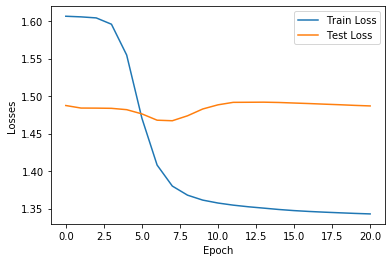

In [86]:
output= np.asarray(output)
print(output.shape)
plt.plot(tr_loss)
plt.plot(te_loss)
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend(['Train Loss','Test Loss'])
plt.show()

In [87]:

output= output.reshape((-1,9))
output.shape

(700, 9)

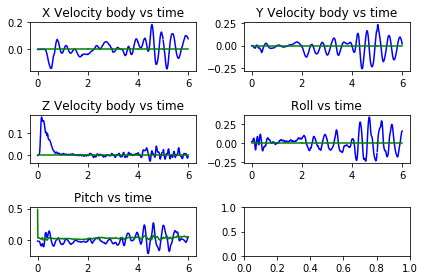

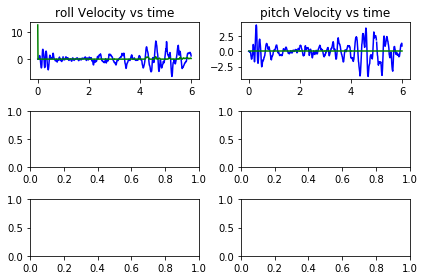

In [88]:
DELTA_T=1/100
trajectory_size= 1
state_traj= test_chunk
rollout_trajs= output.T
total_points = rollout_trajs.shape[1]
X= np.linspace(0,state_traj.shape[1]*DELTA_T,state_traj.shape[1] )
fig,a =  plt.subplots(3,2)
prev=0
for i in range(int(trajectory_size/DELTA_T),total_points,int(trajectory_size/DELTA_T)):
    a[0][0].plot(X[prev:i], test_state_traj[0,prev:i],'b')
    a[0][0].plot(X[prev:i], rollout_trajs[0,prev:i],'g')
    a[0][0].set_title('X Velocity body vs time')
    #a[0][0].legend(('Xposition', 'Yposition', 'Zposition'))
    a[0][1].plot(X[prev:i], state_traj[1,prev:i],'b')
    a[0][1].plot(X[prev:i], rollout_trajs[1,prev:i],'g')
    a[0][1].set_title('Y Velocity body vs time')

    a[1][0].plot(X[prev:i], state_traj[2,prev:i],'b')
    a[1][0].plot(X[prev:i], rollout_trajs[2,prev:i],'g')
    a[1][0].set_title('Z Velocity body vs time')

    a[1][1].plot(X[prev:i], state_traj[3,prev:i],'b')
    a[1][1].plot(X[prev:i], rollout_trajs[3,prev:i],'g')
    a[1][1].set_title('Roll vs time')

    a[2][0].plot(X[prev:i], state_traj[4,prev:i],'b')
    a[2][0].plot(X[prev:i], rollout_trajs[4,prev:i],'g')
    a[2][0].set_title('Pitch vs time')
    prev=i
fig.tight_layout()
fig,b =  plt.subplots(3,2)
prev=0
for i in range(int(trajectory_size/DELTA_T),total_points,int(trajectory_size/DELTA_T)):
    b[0][0].plot(X[prev:i], state_traj[6,prev:i],'b')
    b[0][0].plot(X[prev:i], rollout_trajs[6,prev:i],'g')
    b[0][0].set_title('roll Velocity vs time')
    #a[0][0].legend(('Xposition', 'Yposition', 'Zposition'))
    b[0][1].plot(X[prev:i], state_traj[7,prev:i],'b')
    b[0][1].plot(X[prev:i], rollout_trajs[7,prev:i],'g')
    b[0][1].set_title('pitch Velocity vs time')
    prev=i
fig.tight_layout()
plt.show()


In [89]:
Kl  = 0
mse = 0
Aic = 0
Bic = 0
for i in range(9):
    Kl+= information_scores.KL_divergence(state_traj[i,:700],rollout_trajs[i,:])
    mse+= information_scores.MSE(state_traj[i, :700], rollout_trajs[i, :])
    Aic+= information_scores.AIC(state_traj[i, :700], rollout_trajs[i, :],2)
    Bic += information_scores.BIC(state_traj[i, :700], rollout_trajs[i, :], 2)
print(Kl, mse,Aic,Bic)



27.107977699154038 13.318907574338155 -13774.98992739744 -13693.070481366663


In [83]:
state_traj.shape

(12, 701)